In [1]:
!pip install numpy pandas opencv-python scikit-image matplotlib shutil

Could not fetch URL https://pypi.org/simple/shutil/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/shutil/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1000)'))) - skipping
ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil


In [2]:
from PIL import Image
import os
from multiprocessing import Pool, cpu_count


def process_image(file_path):
    try:
        with Image.open(file_path) as img:
            img = img.convert("RGB")  # RGB formatına çevir
            img = img.resize((224, 224))  # 224x224 boyutuna yeniden boyutlandır
            img.save(file_path, format="JPEG")  # Dosyayı kaydet
            return f"{file_path}: İşlendi."
    except Exception as e:
        return f"{file_path}: Hata - {e}"

def resize_and_overwrite_images_parallel(root_directory):
    supported_formats = (".png", ".jpg", ".jpeg")
    image_paths = [os.path.join(root, file)
                   for root, _, files in os.walk(root_directory)
                   for file in files if file.lower().endswith(supported_formats)]

    with Pool(processes=cpu_count()) as pool:
        results = pool.map(process_image, image_paths)
    for result in results:
        print(result)

# Kullanım
dataset_path = "/home/kubilaybey/Documents/fruit_model/Fruit -Database/Fruit Data _Base"  # Veri seti ana klasörü
output_path = "/home/kubilaybey/Documents/fruit_model/Fruit -Database"  # Veri seti ana klasörü

# Çok çekirdekli işleme başla
resize_and_overwrite_images_parallel(dataset_path)


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [3]:
import os
import cv2
import numpy as np

# Veri setindeki görselleri yükleme
def load_images_from_folder(folder_path, img_size=(224, 224)):
    images, labels = [], []
    for root, _, files in os.walk(folder_path):
        for file in files:
            img_path = os.path.join(root, file)
            label = os.path.basename(root)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)


images, labels = load_images_from_folder(dataset_path)

print(f"Toplam Görsel: {len(images)}, Toplam Etiket: {len(labels)}")


Toplam Görsel: 66407, Toplam Etiket: 66407


In [10]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from multiprocessing import Pool
from sklearn.preprocessing import LabelEncoder

# Tek bir görüntüden özellik çıkarma
def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Sap tespiti için eşikleme
    _, stem_mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

    # Doku analizi (LBP)
    radius = 3  # Radius değerini burada belirtiyoruz
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')

    # Renk analizi (RGB histogram)
    color_hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    color_hist = cv2.normalize(color_hist, color_hist).flatten()

    return {
        "stem_mask": stem_mask,
        "texture": lbp,
        "color_histogram": color_hist
    }

# Tek bir dosya üzerinde işlem yapan yardımcı fonksiyon
def process_file(file_info):
    img_path, label = file_info
    img = cv2.imread(img_path)
    if img is not None:
        features = extract_features(img)
        return features["color_histogram"], label
    return None  # Hatalı dosyalar için None döndür

# Veri setini işleyen fonksiyon (çok çekirdekli)
def extract_features_from_dataset_parallel(folder_path, num_processes):
    file_info_list = []

    # Tüm dosya yollarını ve etiketleri toplar
    for root, _, files in os.walk(folder_path):
        for file in files:
            img_path = os.path.join(root, file)
            label = os.path.basename(root)  # Klasör ismini etiket olarak kullanır
            file_info_list.append((img_path, label))

    # Çok çekirdekli işleme
    with Pool(processes=num_processes) as pool:
        results = pool.map(process_file, file_info_list)

    # Sonuçları ayrıştır
    features = []
    labels = []
    for result in results:
        if result is not None:  # Eğer sonuç geçerliyse
            features.append(result[0])
            labels.append(result[1])

    return np.array(features), np.array(labels)

# Veri setinin yolu
dataset_path = "/home/kubilaybey/Documents/fruit_model/Fruit -Database/Fruit Data _Base"

# Görsellerden özellik çıkarma ve etiketleri alma
image_features, labels = extract_features_from_dataset_parallel(dataset_path, num_processes=12)

# Etiketleri encode et
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Sonuçları yazdır
print("Encoded Labels:", labels_encoded[:10])  # İlk 10 etiketin dönüşümünü kontrol edin
print(f"Özellik Boyutu: {image_features.shape}, Etiket Boyutu: {labels_encoded.shape}")

# Örneğin ilk görüntüden çıkarılan özelliklere bakalım
print(f"Örnek Color Histogram Shape: {image_features[0].shape}")


Encoded Labels: [0 0 0 0 0 0 0 0 0 0]
Özellik Boyutu: (66407, 512), Etiket Boyutu: (66407,)
Örnek Color Histogram Shape: (512,)


In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Concatenate, Dropout

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

image_input = Input(shape=(224, 224, 3), name="image_input")
feature_input = Input(shape=(512,), name="feature_input")

x = base_model(image_input)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)

combined = Concatenate()([x, feature_input])
combined = Dropout(0.4)(combined)

output = Dense(len(set(labels)), activation='softmax')(combined)
model = Model(inputs=[image_input, feature_input], outputs=output)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


2025-01-02 20:39:46.539442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735839586.553572   60938 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735839586.557758   60938 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 20:39:46.573029: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1735839588.594660   60938 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 62

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ image_input[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_input       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1792)      │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ feature_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1792)      │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 26)        │     46,618 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,304,602 (8.79 MB)

 Trainable params: 46,618 (182.10 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Model mimarisi
#def create_model(input_shape):
#    image_input = tf.keras.Input(shape=input_shape, name="image_input")
#    feature_input = tf.keras.Input(shape=(512,), name="feature_input")  # Renk histogramı için
#
#    # CNN kısmı
#    x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
#    x = layers.MaxPooling2D((2, 2))(x)
#    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
#    x = layers.MaxPooling2D((2, 2))(x)
#    x = layers.Flatten()(x)
#
#    # Özelliklerin birleştirilmesi
#    combined = layers.Concatenate()([x, feature_input])
#
#    # Çıkış katmanı
#    output = layers.Dense(len(set(labels)), activation='softmax')(combined)
#
#    model = models.Model(inputs=[image_input, feature_input], outputs=output)
#    return model
#
# Modeli oluştur ve derle
#model = create_model((224, 224, 3))
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#
#print(model.summary())

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Yeni veri yolları
train_dir = os.path.join(output_path, "train")
val_dir = os.path.join(output_path, "val")
test_dir = os.path.join(output_path, "test")

# Veri artırma ve yeniden ölçeklendirme
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Jeneratörler
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    num_workers=12
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    num_workers=12
)

test_generator = test_datagen.flow_from_directory(
    test_dir,  # Test veri klasörü
    target_size=(224, 224),  # Görüntü boyutu
    batch_size=32,
    class_mode="binary",  # İkili sınıflandırma
    num_workers=12
)

print("Eğitim, doğrulama ve test jeneratörleri hazır.")

TypeError: ImageDataGenerator.flow_from_directory() got an unexpected keyword argument 'num_workers'

In [14]:
def combined_generator(image_gen, features):
    for batch, labels in image_gen:
        batch_index = image_gen.index_array[:len(batch)]
        yield {"image_input": batch, "feature_input": features[batch_index]}, labels


# Eğitim ve doğrulama jeneratörleri
train_combined_gen = combined_generator(train_generator, image_features)
val_combined_gen = combined_generator(val_generator, image_features)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

train_combined_gen = combined_generator(train_generator, image_features)
val_combined_gen = combined_generator(val_generator, image_features)

# Modeli eğit
history = model.fit(
    train_combined_gen,
    validation_data=val_combined_gen,
    epochs=5,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

Epoch 1/5


I0000 00:00:1735839594.979319   67462 service.cc:148] XLA service 0x72e594001ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735839594.979336   67462 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-01-02 20:39:55.065445: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735839595.621620   67462 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1241 ━━━━━━━━━━━━━━━━━━━━ 3:20:49 10s/step - accuracy: 0.0312 - loss: 4.1853

I0000 00:00:1735839600.921476   67462 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1241/1241 ━━━━━━━━━━━━━━━━━━━━ 382s 300ms/step - accuracy: 0.7259 - loss: 0.8938 - val_accuracy: 0.9659 - val_loss: 0.1339
Epoch 2/5
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 339s 273ms/step - accuracy: 0.9065 - loss: 0.2753 - val_accuracy: 0.9688 - val_loss: 0.1131
Epoch 3/5
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 328s 264ms/step - accuracy: 0.9155 - loss: 0.2481 - val_accuracy: 0.9749 - val_loss: 0.0855
Epoch 4/5
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 325s 262ms/step - accuracy: 0.9197 - loss: 0.2323 - val_accuracy: 0.9717 - val_loss: 0.0863
Epoch 5/5
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 339s 273ms/step - accuracy: 0.9218 - loss: 0.2328 - val_accuracy: 0.9729 - val_loss: 0.0866


In [16]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model TFLite formatında kaydedildi!")

INFO:tensorflow:Assets written to: /tmp/tmp6xyaiykt/assets


INFO:tensorflow:Assets written to: /tmp/tmp6xyaiykt/assets


Saved artifact at '/tmp/tmp6xyaiykt'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='image_input'), TensorSpec(shape=(None, 512), dtype=tf.float32, name='feature_input')]
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  126335980922512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126335812007312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126335812006736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126335812006928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126335812007696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126335812007888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126335812005776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126335812007120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126335812005584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1263358

W0000 00:00:1735841310.345558   60938 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1735841310.345583   60938 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-01-02 21:08:30.345943: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6xyaiykt
2025-01-02 21:08:30.357002: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-02 21:08:30.357019: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp6xyaiykt
I0000 00:00:1735841310.461132   60938 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-01-02 21:08:30.483001: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-02 21:08:31.120208: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp6xyaiykt
2025-01-02 21:08:31.310976: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

In [24]:
print(model.input_shape)
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape:", input_details[0]['shape'])
print("Input dtype:", input_details[0]['dtype'])
print("Output shape:", output_details[0]['shape'])
print("Output dtype:", output_details[0]['dtype'])

train_data = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=(224, 224), batch_size=32)
class_names = train_data.class_names
print("Sınıf İsimleri:", class_names)

[(None, 224, 224, 3), (None, 512)]
Input shape: [  1 224 224   3]
Input dtype: <class 'numpy.float32'>
Output shape: [ 1 26]
Output dtype: <class 'numpy.float32'>


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Found 39695 files belonging to 14 classes.
Sınıf İsimleri: ['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes', 'muskmelon']


In [28]:

test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


/home/kubilaybey/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: Layer "functional" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(None, 224, 224, 3) dtype=float32>]

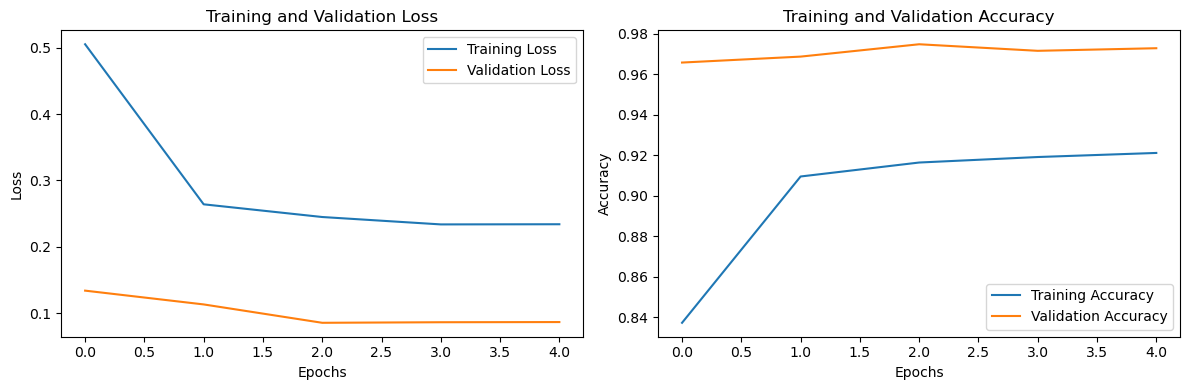

In [30]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama loss grafiği
plt.figure(figsize=(12, 4))

# Loss Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
